# Manipulate atmospheric forcing data to simulate the OTC effect from the field experiment

date created: 2023-04-14

This notebook...

1. documents decisions made with the observational data
2. takes COSMO reanalysis data and makes a modified version of the temperature forcing with 1 degree increased temperature in daytime
3. makes simple plots to check that it worked

Assuming logger placement/removal dates coincide well with OTC placement and removal dates, data from INCLINE_metadata_LoggerDates. csv, https://osf.io/5nmfe, gives these dates:

| Site  | placement  |  removal  |
|  ---- | --------   | --------- |
| Ulvehaugen, ALP1 | 2019-06-11, 2021-06-17 | 2020-09-22, 2021-09-29 |
| Lavisdalen, ALP2 | 2019-06-19, 2021-06-15 | 2020-09-29, 2021-09-28 |
| Gudmedalen, ALP3 | 2019-06-12, 2021-06-16 | 2020-09-30, 2021-09-28 |
| Skjellingahaugen, ALP4 | 2019-06-20, 2021-06-18 | 2020-09-28, 2021-09-27 |

For simplicity, use June 16 and Sept 28 as placement and removal dates for all sites and years. 

In [13]:
# import libraries
import os
import netCDF4 as nc
import xarray as xr  # NetCDF data handling
import pandas as pd
import numpy as np
import datetime as dt
import zipfile # for unzipping
import shutil # easiest whole-directory zipping
from pathlib import Path  # For easy path handling

Read in data. See other notebooks for downloading and unzipping data if necessary. In file explorer, copy the whole data/ALP4_cosmorea folder and name the new copy ALP4_cosmorea_warmed. Use that one to work with while keeping the source folder as a backup if something goes wrong.

In [4]:
# set path to data folder with atmospheric forcing
cosmo_path = str(Path(f"C:/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/data/ALP4_cosmorea_warmed/datmdata"))
print("cosmo_path:", cosmo_path)

gswp3_path = str(Path(f"C:/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/data/ALP4/datmdata"))
print("gswp3_path", gswp3_path)

cosmo_path: C:\Users\evaler\OneDrive - Universitetet i Oslo\Eva\PHD\FATES_INCLINE\data\ALP4_cosmorea_warmed\datmdata
gswp3_path C:\Users\evaler\OneDrive - Universitetet i Oslo\Eva\PHD\FATES_INCLINE\data\ALP4\datmdata


## GSWP3 data modification

In [28]:
example_file = str(Path(gswp3_path + "/" + f"clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1999-07.nc"))
with nc.Dataset(example_file, 'r') as ds:
    # List all variables in the file
    print("Variables:", ds.variables.keys())
    # print some attributes
    for attr_name in ds.ncattrs():
            print(f"  {attr_name}: {getattr(ds, attr_name)}")
    # Access the "time" variable
    time_var = ds.variables['time']
    # Print some info
    print("Variable attributes:", time_var.ncattrs())
    print("Variable calendar:", time_var.calendar)
    print("Variable units:", time_var.units)
    print(time_var[0:20])
    print(ds.variables['time'].units)#'].split(' since ')[1])

Variables: dict_keys(['lon', 'lat', 'time', 'LONGXY', 'LATIXY', 'EDGEE', 'EDGEW', 'EDGES', 'EDGEN', 'PSRF', 'TBOT', 'WIND', 'QBOT', 'FLDS'])
  case_title: GSWP3 3-Hourly Atmospheric Forcing: Temperature, Pressure, Winds, Humidity, and Downward Longwave Radiation.  Missing values for Wind filled with 1948 Qian data interpolated by datm to GSWP3 grid.
  Created_on: 2022-10-27
  Created_by: kavehka
  Created_with: ./subset_data -- 616905bbb
  Created_from: /cluster/shared/noresm/inputdata/atm/datm7/atm_forcing.datm7.GSWP3.0.5d.v1.c170516/TPHWL/clmforc.GSWP3.c2011.0.5x0.5.TPQWL.1999-07.nc
Variable attributes: ['_FillValue', 'long_name', 'units', 'calendar']
Variable calendar: noleap
Variable units: days since 1999-07-01
[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.0625 1.1875
 1.3125 1.4375 1.5625 1.6875 1.8125 1.9375 2.0625 2.1875 2.3125 2.4375]
days since 1999-07-01


Let's choose 06:00 to 18:00 as 'daytime' when we apply the temperature modification. I will choose 1 degree (C or K) as a flat increase.

In [19]:
testfolder = str(Path(gswp3_path + "/warmingtest"))
files = [f for f in os.listdir(testfolder) if f.endswith('.nc')]
print(files)

['clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-01.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-02.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-03.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-04.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-05.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-06.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-07.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-08.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-09.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-10.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-11.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-12.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1902-01.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1902-02.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1902-03.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1902-04.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1902-05.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1902-06.nc', 'clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1902-

In [25]:
testfolder = Path(gswp3_path + "/warmingtest")
files = [f for f in os.listdir(testfolder) if f.endswith('.nc')]
print("working in:", testfolder)

for file in files:
    # Load the .nc file
    file_path = testfolder / file
    print("Processing file:", file_path)
    ds = xr.open_dataset(file_path)  

    # Extract the 'time' variable and convert it to a pandas DatetimeIndex
    time_var = ds['time'].data
    time = pd.to_timedelta(time_var, unit='D') + ds['time'].attrs['units'].split(' since ')[1]
    
    # Define the time range for daytime (06:00 to 18:00)
    start_time = pd.Timestamp('06:00:00')
    end_time = pd.Timestamp('18:00:00')
    
    # Find the indices of time steps that fall within the daytime range (06:00 to 18:00)
    daytime_indices = (time.time >= start_time.time()) & (time.time <= end_time.time())
    print(np.where(daytime_indices)[0])
    
    # Use np.ix_ to create a 1D boolean mask for indexing the temperature variable
    daytime_indices_expanded = np.ix_(daytime_indices)
    
    # Add 1 degree to the temperature variable for the daytime range
    ds['TBOT'].data[daytime_indices_expanded] += 1
    
    # Save the modified data to a new .nc file
    ds.to_netcdf(str(Path(gswp3_path + "/" + file)))

working in: C:\Users\evaler\OneDrive - Universitetet i Oslo\Eva\PHD\FATES_INCLINE\data\ALP4\datmdata\warmingtest
Processing file: C:\Users\evaler\OneDrive - Universitetet i Oslo\Eva\PHD\FATES_INCLINE\data\ALP4\datmdata\warmingtest\clmforc.GSWP3.c2011.0.5x0.5.TPQWL.ALP4.1901-01.nc


ValueError: Invalid type for timedelta scalar: <class 'cftime._cftime.DatetimeNoLeap'>

In [ ]:
testfolder = Path(gswp3_path + "/warmingtest")
files = [f for f in os.listdir(testfolder) if f.endswith('.nc')]
print("working in:", testfolder)

for file in files:
    # Load the .nc file
    file_path = testfolder / file
    print("Processing file:", file_path)
    ds = xr.open_dataset(file_path)  

    # Extract the 'time' variable and convert it to a pandas DatetimeIndex
    date_format = '%Y-%m-%dT%H:%M:%S.%f'

    # Convert to Python datetime object
    time = [dt.datetime.strptime(str(cur_time), date_format)
                    for cur_time in time_var[:]]    

    #time = pd.to_datetime(ds['time'].data, format= date_format)

    # Define the time range for daytime (06:00 to 18:00)
    start_time = pd.Timestamp('1995-01-01 06:00:00')
    end_time = pd.Timestamp('1995-01-01 18:00:00')

    # Find the indices of time steps that fall within the daytime range (06:00 to 18:00)
    daytime_indices = (ds['time'].dt.hour >= 6) & (ds['time'].dt.hour <= 18)
    print(np.where(daytime_indices)[0]) 

    # Use np.ix_ to create a 1D boolean mask for indexing the temperature variable
    daytime_indices_expanded = np.ix_(daytime_indices)  

    # Add 1 degree to the temperature variable for the daytime range
    ds['TBOT'].data[daytime_indices_expanded] += 1  

    # Save the modified data to a new .nc file
    ds.to_netcdf(str(Path(gswp3_path + "/" + file)))

## COSMO data modification

Print some information about the forcing data before deciding how the modification can be done

In [9]:
example_file = str(Path(cosmo_path + "/" + f"clm1pt_ALP4_1995-01.nc"))
with nc.Dataset(example_file, 'r') as ds:
    # List all variables in the file
    print("Variables:", ds.variables.keys())
    # print some attributes
    for attr_name in ds.ncattrs():
            print(f"  {attr_name}: {getattr(ds, attr_name)}")
    # Access the "time" variable
    time_var = ds.variables['time']
    # Print the variable attributes
    print("Variable attributes:", time_var.ncattrs())
    # Print a specific attribute
    print("Variable units:", time_var.units)
    # print 
    print(time_var[:])

Variables: dict_keys(['EDGEW', 'EDGEE', 'EDGES', 'EDGEN', 'LONGXY', 'LATIXY', 'SWDIFDS_RAD', 'SWDIRS_RAD', 'RAIN_CON', 'RAIN_GSP', 'SNOW_GSP', 'SNOW_CON', 'PRECTmms', 'TBOT', 'WIND', 'PSRF', 'SHUM', 'FLDS', 'time'])
  creation_date: ti 21.2.2023 10.20.38 +0100
  history: Original data from COSMOREA6 data
  title: CLM single point datm input data
  conventions: CF-1.0
  case_title: COSMOREA6: SEEDCLIM
  time:calendar: gregorian
Variable attributes: ['standard_name', 'units', 'calendar', 'axis']
Variable units: hours since 1995-1-1 01:00:00
[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 258. 261. 264. 267

The data is provided at 3-hourly time steps. Let's choose 06:00 to 18:00 as 'daytime' when we apply the temperature modification. I will choose 1 degree (C or K) as a flat increase.

In [27]:
# Load the .nc file
ds = xr.open_dataset(example_file)

# Extract the 'time' variable and convert it to a pandas DatetimeIndex
time = pd.to_datetime(ds['time'].data, format='%Y-%m-%d %H:%M:%S')

# Define the time range for daytime (06:00 to 18:00)
start_time = pd.Timestamp('1995-01-01 06:00:00')
end_time = pd.Timestamp('1995-01-01 18:00:00')

# Find the indices of time steps that fall within the daytime range (06:00 to 18:00)
daytime_indices = (ds['time'].dt.hour >= 6) & (ds['time'].dt.hour <= 18)
print(np.where(daytime_indices)[0])

# Use np.ix_ to create a 1D boolean mask for indexing the temperature variable
daytime_indices_expanded = np.ix_(daytime_indices)

# Add 1 degree to the temperature variable for the daytime range
ds['TBOT'].data[daytime_indices_expanded] += 1

# Save the modified data to a new .nc file
ds.to_netcdf(str(Path(cosmo_path + "/" + f"clm1pt_ALP4_1995-01.nc")))

[  2   3   4   5  10  11  12  13  18  19  20  21  26  27  28  29  34  35
  36  37  42  43  44  45  50  51  52  53  58  59  60  61  66  67  68  69
  74  75  76  77  82  83  84  85  90  91  92  93  98  99 100 101 106 107
 108 109 114 115 116 117 122 123 124 125 130 131 132 133 138 139 140 141
 146 147 148 149 154 155 156 157 162 163 164 165 170 171 172 173 178 179
 180 181 186 187 188 189 194 195 196 197 202 203 204 205 210 211 212 213
 218 219 220 221 226 227 228 229 234 235 236 237 242 243 244 245]


Print some info about an example file again to check whether it worked, without breaking anything

In [26]:
example_file = str(Path(cosmo_path + "/" + f"clm1pt_ALP4_1995-01.nc"))
with nc.Dataset(example_file, 'r') as ds:
    # List all variables in the file
    print("Variables:", ds.variables.keys())
    # print some attributes
    for attr_name in ds.ncattrs():
            print(f"  {attr_name}: {getattr(ds, attr_name)}")
    # Access the "time" variable
    time_var = ds.variables['time']
    # Print the variable attributes
    print("Variable attributes:", time_var.ncattrs())
    # Print a specific attribute
    print("Variable units:", time_var.units)
    # print 
    print(time_var[:])

Variables: dict_keys(['EDGEW', 'EDGEE', 'EDGES', 'EDGEN', 'LONGXY', 'LATIXY', 'SWDIFDS_RAD', 'SWDIRS_RAD', 'RAIN_CON', 'RAIN_GSP', 'SNOW_GSP', 'SNOW_CON', 'PRECTmms', 'TBOT', 'WIND', 'PSRF', 'SHUM', 'FLDS', 'time'])
  creation_date: ti 21.2.2023 10.20.38 +0100
  history: Original data from COSMOREA6 data
  title: CLM single point datm input data
  conventions: CF-1.0
  case_title: COSMOREA6: SEEDCLIM
  time:calendar: gregorian
Variable attributes: ['_FillValue', 'standard_name', 'axis', 'units', 'calendar']
Variable units: hours since 1995-01-01T01:00:00
[  0.   3.   6.   9.  12.  15.  18.  21.  24.  27.  30.  33.  36.  39.
  42.  45.  48.  51.  54.  57.  60.  63.  66.  69.  72.  75.  78.  81.
  84.  87.  90.  93.  96.  99. 102. 105. 108. 111. 114. 117. 120. 123.
 126. 129. 132. 135. 138. 141. 144. 147. 150. 153. 156. 159. 162. 165.
 168. 171. 174. 177. 180. 183. 186. 189. 192. 195. 198. 201. 204. 207.
 210. 213. 216. 219. 222. 225. 228. 231. 234. 237. 240. 243. 246. 249.
 252. 255. 25

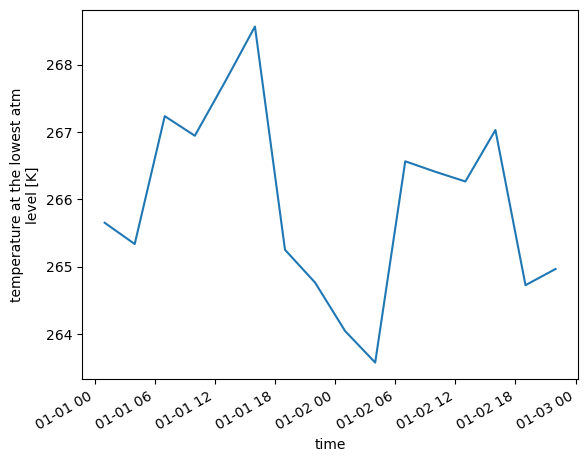

In [30]:

# Subset the temperature variable for the first two days
temperature_subset = ds['TBOT'].sel(time=slice('1995-01-01', '1995-01-02'))

# Plot the temperature variable for the first two days
temperature_subset.plot()